In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import seaborn as sns
sns.set_style("whitegrid")
import graphviz
from graphviz import Digraph
from IPython.display import Image, display

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
DATA_PATH = "~/Projects/Anomaly-Detection-Auto-Encoder/data"
WINDOW_SIZE = 60
BATCH_SIZE = 64
SEQ_LEN = 1 # just keeping this to one for now, would it be better to make it larger?

# loading and combining "normal data" into one dataframe, from which individual windows will be extracted
normal_files = ["sine.csv", "sawtooth.csv", "square.csv"]
dfs = []

for file in normal_files:
    df = pd.read_csv(Path(DATA_PATH)/file).drop(columns=['timestamp'])
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
print(f"Total samples: {len(full_df)}")

# normalizing data, based off of original code. check with Eugene, should we use MinMax?
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df)

Total samples: 32771


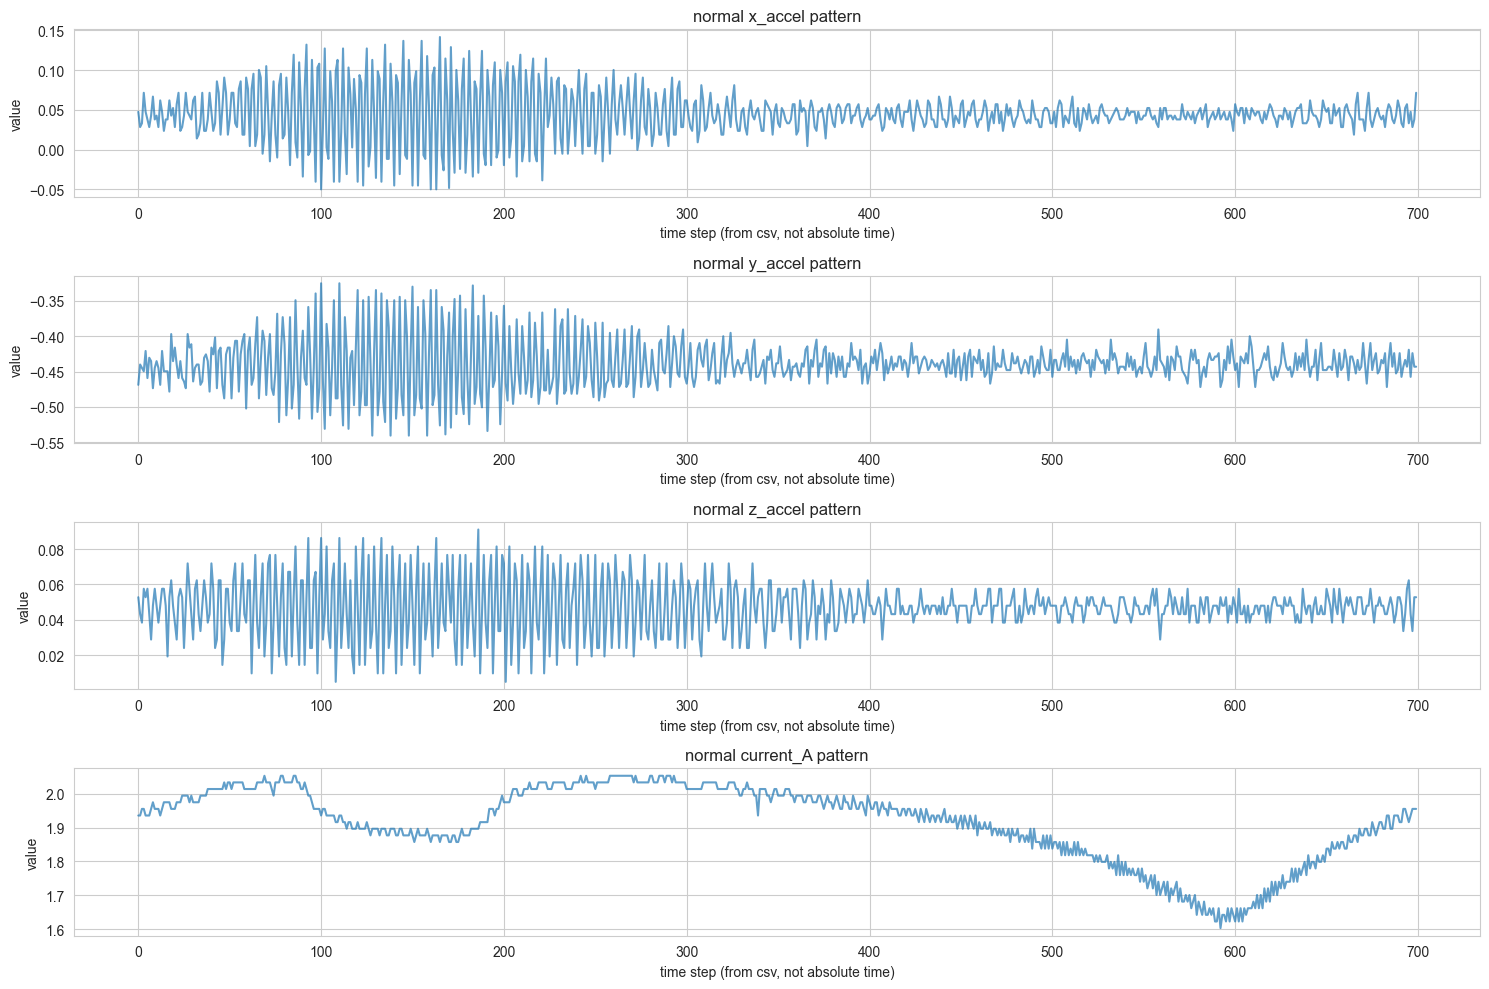

In [6]:
# quick visualization of original data (sanity check)

plt.figure(figsize=(15, 10))
for i, col in enumerate(full_df.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(full_df[col].values[:700], alpha=0.7)
    plt.title(f'normal {col} pattern')
    plt.xlabel('time step (from csv, not absolute time)')
    plt.ylabel('value')
plt.tight_layout()
plt.show()

In [7]:
# creating overlapping sequences of data
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

sequences = create_sequences(scaled_data, WINDOW_SIZE)
X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=42)

# tensor conversion
train_data = torch.FloatTensor(X_train)
val_data = torch.FloatTensor(X_val)

train_loader = DataLoader(TensorDataset(train_data, train_data), 
                       batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data, val_data), 
                      batch_size=BATCH_SIZE)

In [8]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.input_dim = input_dim    # 4 features (x,y,z accel + current)
        self.hidden_dim = hidden_dim  # Latent space dimension
        self.seq_len = seq_len        # Window size
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Final feature reconstruction
        self.fc = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Decoder input (initialized with zeros)
        decoder_input = torch.zeros(x.size(0), self.seq_len, self.hidden_dim).to(x.device)
        
        # Decoder with encoder's hidden state
        decoder_output, _ = self.decoder(decoder_input, (hidden, cell))
        
        # Reconstruct original features
        return self.fc(decoder_output)

# Initialize model
WINDOW_SIZE = 60
model = LSTM_Autoencoder(
    input_dim=4,     # x_accel, y_accel, z_accel, current_A
    hidden_dim=32,   # Latent dimension
    seq_len=WINDOW_SIZE
)
print(model)

LSTM_Autoencoder(
  (encoder): LSTM(4, 32, batch_first=True)
  (decoder): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)


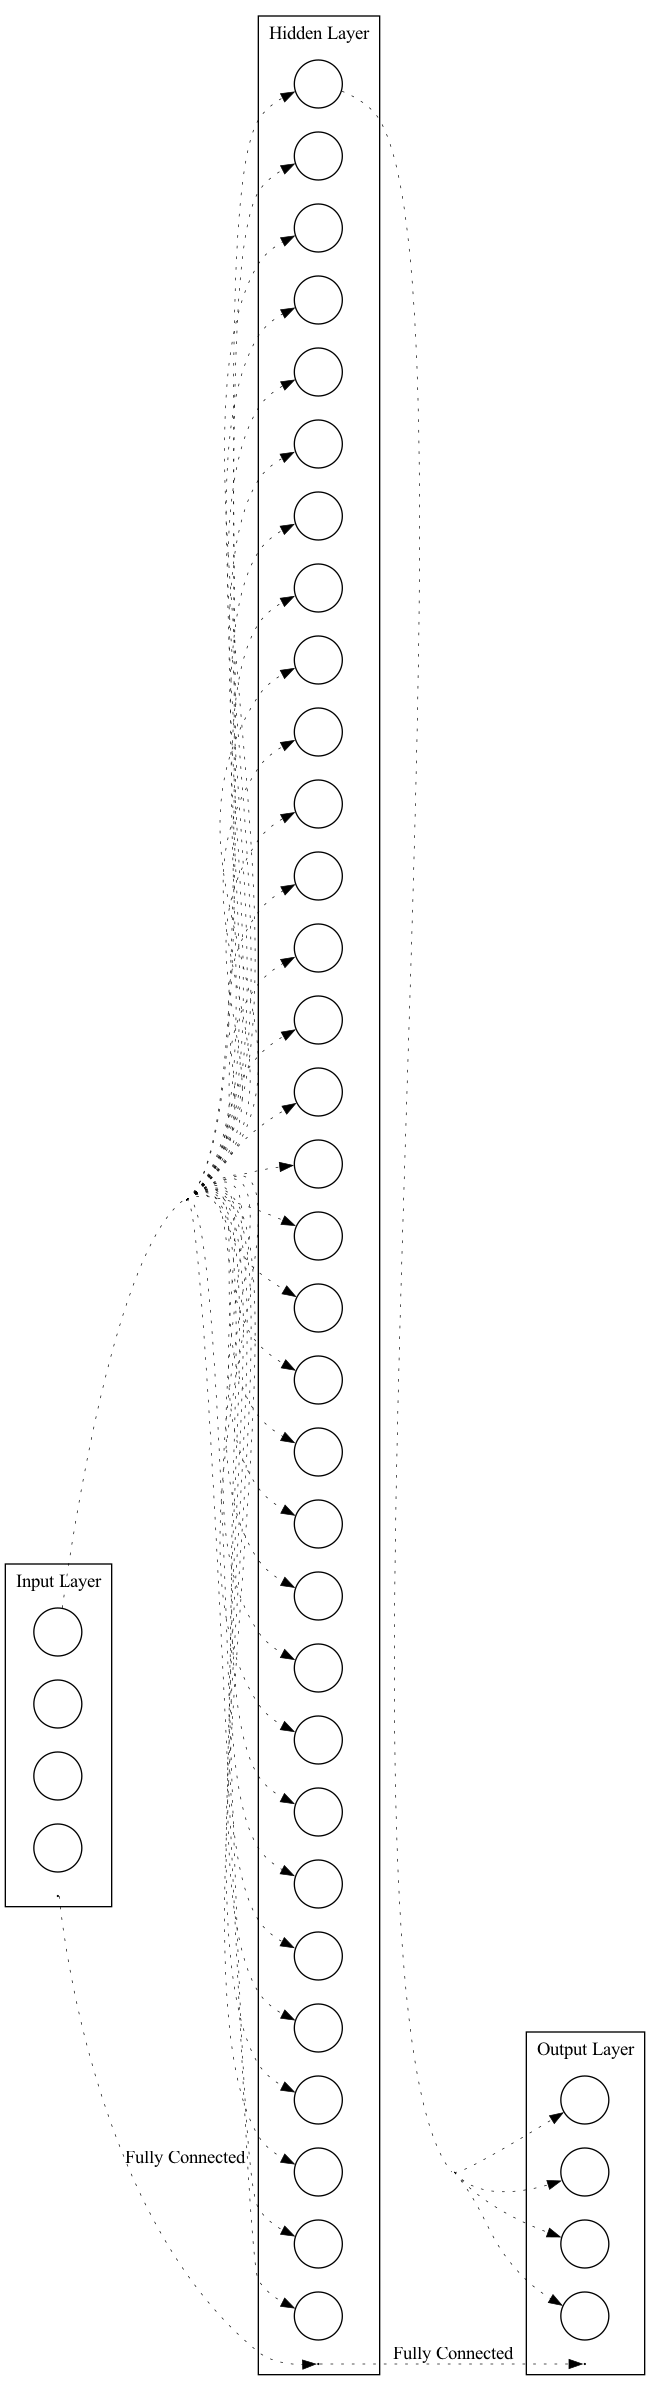

In [9]:
dot = Digraph(comment="LSTM Autoencoder Detailed Diagram", format="png")
dot.attr(rankdir="LR", concentrate="true")  # Use graph edge concentration

# Input layer: 4 neurons (represented individually) with a dummy node for aggregate connection
with dot.subgraph(name="cluster_input") as c:
    c.attr(rank="same", label="Input Layer")
    for i in range(4):
        c.node(f"I{i}", shape="circle", label="")
    c.node("input_dummy", shape="point", width="0.01")

# Hidden layer: 32 neurons (represented individually) with a dummy node for aggregate connections
with dot.subgraph(name="cluster_hidden") as c:
    c.attr(rank="same", label="Hidden Layer")
    for i in range(32):
        c.node(f"H{i}", shape="circle", label="")
    c.node("hidden_dummy", shape="point", width="0.01")

# Output layer: 4 neurons (represented individually) with a dummy node for aggregate connection
with dot.subgraph(name="cluster_output") as c:
    c.attr(rank="same", label="Output Layer")
    for i in range(4):
        c.node(f"O{i}", shape="circle", label="")
    c.node("output_dummy", shape="point", width="0.01")

# Draw aggregate edges between groups using the dummy nodes
dot.edge("input_dummy", "hidden_dummy", style="dotted", penwidth="0.5", label="Fully Connected")
dot.edge("hidden_dummy", "output_dummy", style="dotted", penwidth="0.5", label="Fully Connected")

# Optionally, display individual connections for a subset (e.g., from the first neuron)
for j in range(32):
    dot.edge("I0", f"H{j}", style="dotted", penwidth="0.5")
for k in range(4):
    dot.edge("H0", f"O{k}", style="dotted", penwidth="0.5")

# Display the diagram inline using IPython.display
display(Image(dot.pipe(format='png')))


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss() #should we use MAE?
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Verify dimensions
test_input = torch.randn(64, WINDOW_SIZE, 4).to(device)  # 64 batch size
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")   # should be [64, 60, 4]
print(f"Output shape: {test_output.shape}") # should also be same as above

# training loop
NUM_EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device) #sending batches to device in case of gpu usage
        optimizer.zero_grad() #resetting gradients
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validation on the "test" split of the data; is the model generalizing?
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    
    # recording losses for plotting
    epoch_train_loss = train_loss/len(train_loader)
    epoch_val_loss = val_loss/len(val_loader)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | '
          f'Train Loss: {epoch_train_loss:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f}')

Input shape: torch.Size([64, 60, 4])
Output shape: torch.Size([64, 60, 4])
Epoch 1/100 | Train Loss: 0.8741 | Val Loss: 0.8163
Epoch 2/100 | Train Loss: 0.7884 | Val Loss: 0.7851
Epoch 3/100 | Train Loss: 0.7735 | Val Loss: 0.7760
Epoch 4/100 | Train Loss: 0.7695 | Val Loss: 0.7749
Epoch 5/100 | Train Loss: 0.7653 | Val Loss: 0.7675
Epoch 6/100 | Train Loss: 0.7602 | Val Loss: 0.7658
Epoch 7/100 | Train Loss: 0.7584 | Val Loss: 0.7637
Epoch 8/100 | Train Loss: 0.7576 | Val Loss: 0.7629
Epoch 9/100 | Train Loss: 0.7569 | Val Loss: 0.7627
Epoch 10/100 | Train Loss: 0.7571 | Val Loss: 0.7652
Epoch 11/100 | Train Loss: 0.7568 | Val Loss: 0.7622
Epoch 12/100 | Train Loss: 0.7560 | Val Loss: 0.7618
Epoch 13/100 | Train Loss: 0.7567 | Val Loss: 0.7626
Epoch 14/100 | Train Loss: 0.7571 | Val Loss: 0.7626
Epoch 15/100 | Train Loss: 0.7563 | Val Loss: 0.7623
Epoch 16/100 | Train Loss: 0.7559 | Val Loss: 0.7616
Epoch 17/100 | Train Loss: 0.7559 | Val Loss: 0.7616
Epoch 18/100 | Train Loss: 0.7555

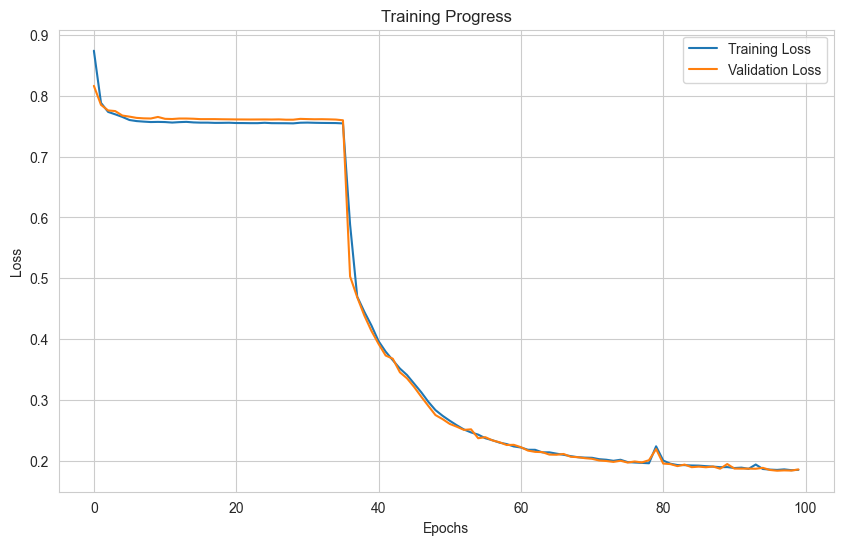

In [11]:
# visualizing loss decrease (hopefully) overtime

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# finding a threshold for anomaly detection

model.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        error = torch.mean((outputs - inputs)**2, dim=(1,2)).cpu().numpy()
        reconstruction_errors.extend(error)

threshold = np.percentile(reconstruction_errors, 99) # if the error is in the top 1% of the distribution, consider it an anomaly
print(f"Anomaly Threshold: {threshold:.4f}")

Anomaly Threshold: 0.5479


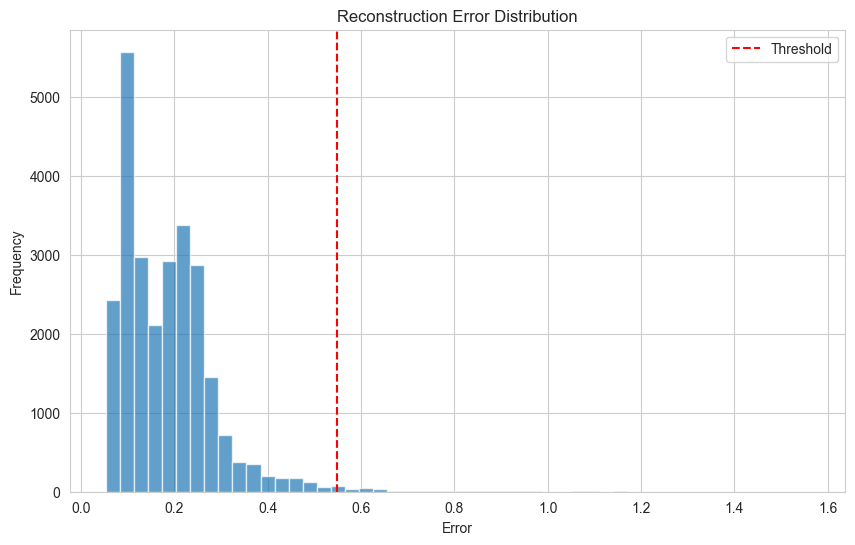

In [13]:
# visualize error distribution

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
# making a function for passing in some csv and detecting anomalies

def detect_anomalies(file_path, model, scaler, threshold):
    # load and preprocess data (like in training)
    df = pd.read_csv(file_path).drop(columns=['timestamp'])
    scaled_data = scaler.transform(df.values)
    sequences = create_sequences(scaled_data, WINDOW_SIZE)
    
    # tensor conversion, batch size implementation
    test_loader = DataLoader(TensorDataset(torch.FloatTensor(sequences)), 
                           batch_size=BATCH_SIZE)
    
    errors = [] # storing errors for visualization
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            batch_errors = torch.mean((outputs - inputs)**2, dim=(1,2)).cpu().numpy() # mean squared error
            errors.extend(batch_errors) # storing errors in the list
    
    # detecting anomalies
    anomalies = np.array(errors) > threshold # classifying anomalies where error is greater than threshold
    return df, errors, anomalies

/Users/paras/Projects/Anomaly-Detection-Auto-Encoder/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


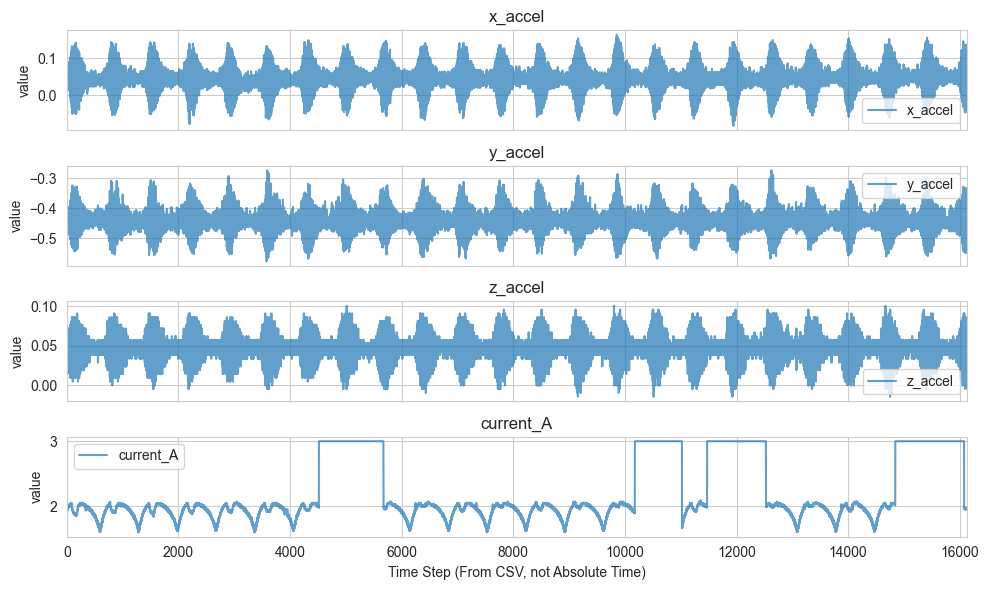

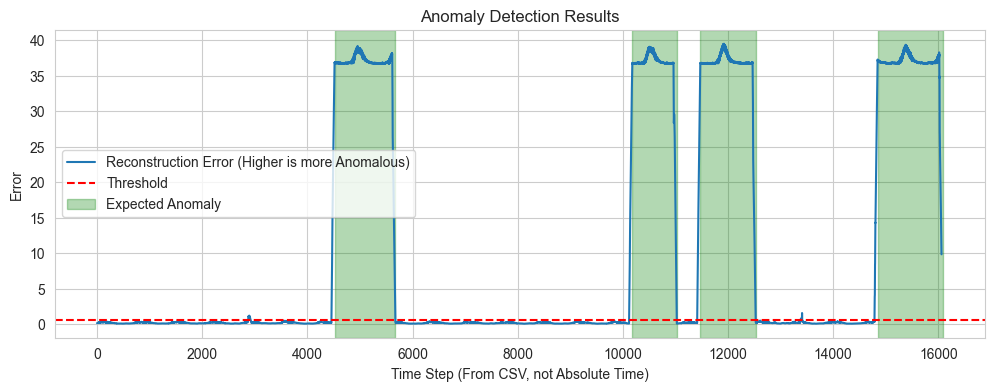

In [17]:
test_file = "sineanom.csv"  
raw_data, errors, anomalies = detect_anomalies(test_file, model, scaler, threshold)

# plot sensor readings (original data)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)
for i, (ax, col) in enumerate(zip(axes, raw_data.columns)):
    ax.plot(raw_data[col], alpha=0.7, label=col)
    
    ax.set_title(f'{col}')
    ax.set_ylabel('value')
    ax.legend()
    
axes[-1].set_xlabel('Time Step (From CSV, not Absolute Time)')
axes[-1].set_xlim(0, len(raw_data))
plt.tight_layout()
plt.show()

# plotting error progression
plt.figure(figsize=(12, 4))
plt.plot(errors, label='Reconstruction Error (Higher is more Anomalous)')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')

# expected anomaly regions highlighted in green
expected_regions = [(4519, 5675), (10180, 11024), (11475, 12528), (14847, 16079)] # manually annotated
for start, end in expected_regions:
    plt.axvspan(start, end, color='green', alpha=0.3, label='Expected Anomaly')

# avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title('Anomaly Detection Results')
plt.xlabel('Time Step (From CSV, not Absolute Time)')
plt.ylabel('Error')
plt.show()

In [16]:
torch.save(model.state_dict(), "lstm_autoencoder.pth") # save the model if you want